In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
def using_contours(src_img_path):
    image = cv2.imread(src_img_path)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    threshold_value = 150
    pp, binary = cv2.threshold(gray, threshold_value, 255, cv2.THRESH_BINARY)
    contours,qq = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    mask = np.zeros_like(binary)
    for contour in contours:
        cv2.drawContours(mask, [contour], -1, (255), thickness=cv2.FILLED)
    segmented_image = cv2.bitwise_and(image, image, mask=mask)
    plt.imshow(segmented_image)
    return segmented_image

In [3]:
# import the necessary packages
from skimage import exposure

def using_match_histogram(img, ref_img):
	# load the source and reference images
	print("[INFO] loading source and reference images...")
	src = img
	ref = ref_img
	# determine if we are performing multichannel histogram matching
	# and then perform histogram matching itself
	print("[INFO] performing histogram matching...")
	multi = 2 if src.shape[-1] > 1 else None
	matched = exposure.match_histograms(src, ref, channel_axis=multi)
	plt.imshow(matched)
	return matched

In [10]:
def using_adaptive_threshold(src):
    # Convert the image to HSV color space
    hsv = cv2.cvtColor(src, cv2.COLOR_RGB2HSV)

    # Separate the value channel from the HSV image
    v = hsv[:,:,2]

    # Apply adaptive thresholding to create a mask for the shadow regions
    mask = cv2.adaptiveThreshold(v, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY_INV, 11, 2)
    # Soften the edges of the mask with a Gaussian blur
    mask = cv2.GaussianBlur(mask, (21,21), 0)
    plt.imshow(mask)    

    # Invert the mask so that the shadow regions are white
    mask = cv2.bitwise_not(mask)

    # Blend the original image with a white image using the mask as the alpha channel
    result = cv2.merge((v,v,v)) # Create a grayscale version of the image
    result = cv2.addWeighted(result, 0.9, cv2.merge((mask,mask,mask)), 0.1, 0)
    return result

In [104]:
def match_shadows_and_contrast(source_image, target_image):
  # Convert the images to the HSV color space
  s_hsv = cv2.cvtColor(source_image, cv2.COLOR_RGB2HSV)
  t_hsv = cv2.cvtColor(target_image, cv2.COLOR_RGB2HSV)
  
  # Get the shadows and highlights of the source image
  src_shadows = s_hsv[:, :, 2] < 150
  src_highlights = s_hsv[:, :, 2] > 255 / 2

  # Set the shadows and highlights of the target image to match the source image
  t_hsv[src_shadows] = 0
  t_hsv[src_highlights] = 255
  t_hsv = cv2.GaussianBlur(t_hsv, (21,21), 0)
  # t_hsv = cv2.bitwise_not(t_hsv)
  # plt.imshow(t_hsv)
  # print(t_hsv.shape)

    
  # Convert the target image back to the BGR color space
  rgb_res = cv2.cvtColor(t_hsv, cv2.COLOR_HSV2RGB)
  gray_res = cv2.cvtColor(rgb_res, cv2.COLOR_RGB2GRAY)
  
  gray_src = cv2.cvtColor(source_image, cv2.COLOR_RGB2GRAY)
  result = cv2.addWeighted(gray_src, 0.2, gray_res, 0.8, 0)
  
  print(gray_res)
  _,alpha = cv2.threshold(gray_res, 164, 0, cv2.THRESH_BINARY)
  print(alpha)

  b, g, r = cv2.split(rgb_res)
  rgba = [b,g,r, alpha]
  dst = cv2.merge(rgba,4)
  plt.imshow(dst)
  # Return the target image
  # return cv2.cvtColor(result, cv2.COLOR_GRAY2RGB)
  return dst

### Illuminating the overlayed img

In [6]:
test_img = "img3"

src_img = cv2.cvtColor(cv2.imread("../inputs/src_imgs/{}/{}.jpeg".format(test_img, test_img)), cv2.COLOR_BGR2RGB)
out_img = cv2.cvtColor(cv2.imread("../outs/{}.jpg".format(test_img)), cv2.COLOR_BGR2RGB)

[[164 164 164 ...   0   0   0]
 [164 164 164 ...   0   0   0]
 [164 164 164 ...   0   0   0]
 ...
 [  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]]
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


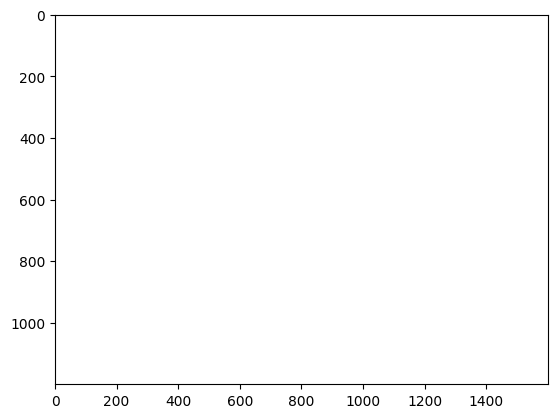

In [105]:
illumination = match_shadows_and_contrast(src_img, out_img)

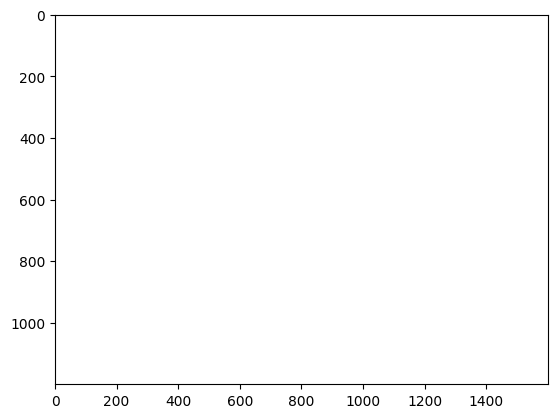

In [106]:
plt.imshow(illumination)

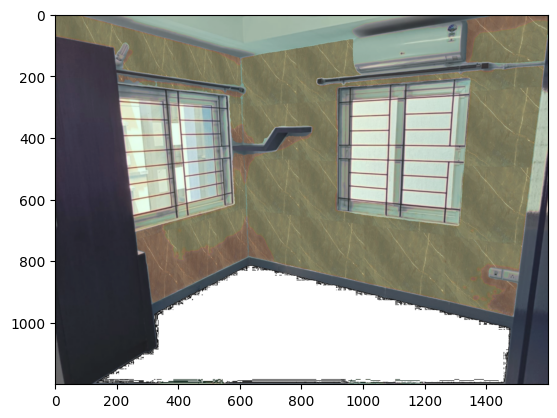

In [100]:
alpha = np.sum(out_img, axis=-1) > 0

# Convert True/False to 0/255 and change type to "uint8" to match "na"
alpha = np.uint8(alpha * 255)

# Stack new alpha layer with existing image to go from BGR to BGRA, i.e. 3 channels to 4 channels
result_out = np.dstack((out_img, alpha))

img = cv2.addWeighted(result_out, 0.9, illumination, 0.1, 0)
plt.imshow(img)

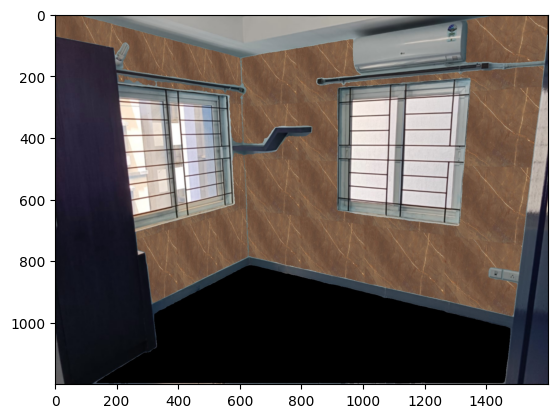

In [56]:
plt.imshow(out_img)